# 1. Data Exploration

In [4]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder

In [5]:
df_users = pd.read_csv('/Users/alexk/Desktop/datathon/sd254_users.csv')

In [6]:
df_trans = pd.read_csv('/Users/alexk/Desktop/datathon/credit_card_transactions-ibm_v2.csv')

In [7]:
df_users.head()

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [8]:
df_trans.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [9]:
unique_Users = df_trans['User'].unique()
selected_cards = pd.Series(unique_Users).sample(frac=0.4, replace=False, random_state=42)
filtered_transactions = df_trans[df_trans['User'].isin(selected_cards)]

In [10]:
df = filtered_transactions.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9688065 entries, 28882 to 24382138
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 1.2+ GB


In [11]:
df.isnull().sum()

User                    0
Card                    0
Year                    0
Month                   0
Day                     0
Time                    0
Amount                  0
Use Chip                0
Merchant Name           0
Merchant City           0
Merchant State    1132934
Zip               1197293
MCC                     0
Errors?           9532311
Is Fraud?               0
dtype: int64

# 2. Data Cleaning

In [12]:
df['Amount'] = df['Amount'].str.replace('$','').astype(float)

In [13]:
df['Hour'] = df['Time'].str[0:2]
df['Minute'] = df['Time'].str[3:5]
df = df.drop(['Time'], axis=1)

In [14]:
df['Is Fraud?'] = df['Is Fraud?'].apply(lambda x: 1 if x == 'Yes' else 0)

In [15]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
28882,2,0,2009,9,26,948.44,Online Transaction,3694722044710185708,ONLINE,NaN,NaN,4722,NaN,0,01,56
28883,2,0,2009,10,1,42.98,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,0,04,13
28884,2,0,2009,10,1,9.85,Swipe Transaction,-4891055843221560993,West Covina,CA,91792.0,5411,NaN,0,10,49
28885,2,0,2009,10,1,36.39,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,0,14,30
28886,2,0,2009,10,2,56.60,Online Transaction,-6458444334611773637,ONLINE,NaN,NaN,4784,NaN,0,04,25


In [16]:
fraud_data=df[df['Is Fraud?']==1]

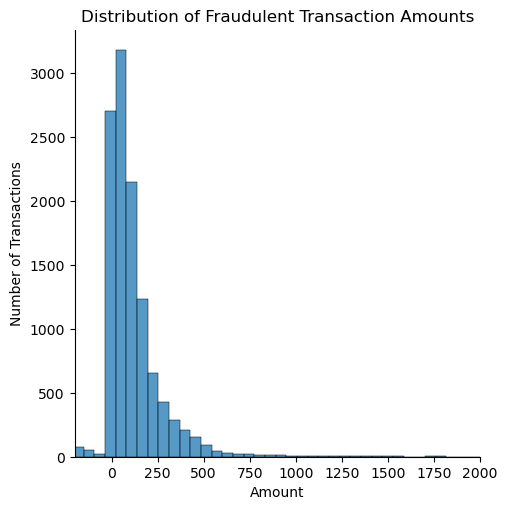

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(fraud_data['Amount'].astype(float), kde=False, bins=80)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim(-200, 2000)
plt.show()

C:\Users\alexk\AppData\Local\Temp\ipykernel_93352\678193434.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fraud_data, x='Day of Week', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], palette="Blues_d")


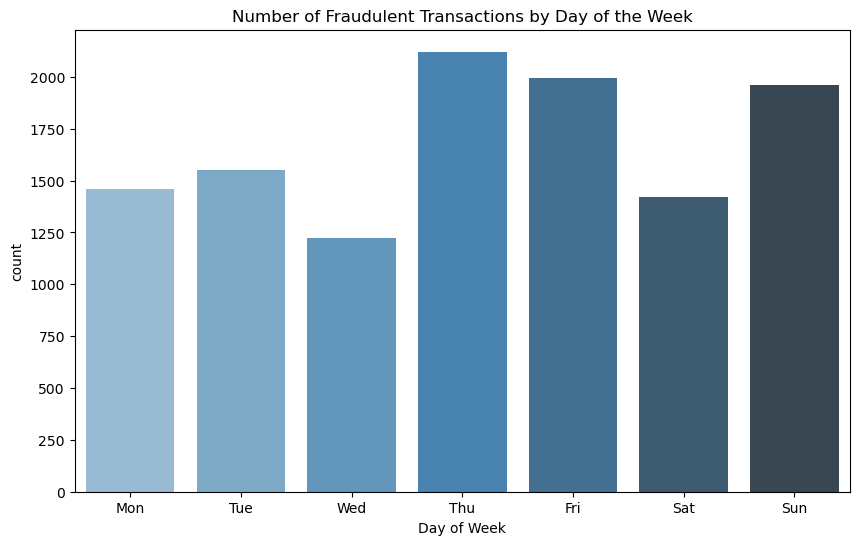

In [18]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Extract day of the week and map it to its name
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['Day of Week'] = df['Date'].dt.dayofweek.map(days)

fraud_data = df[df['Is Fraud?'] == 1]

# Visualize
plt.figure(figsize=(10, 6))
sns.countplot(data=fraud_data, x='Day of Week', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], palette="Blues_d")
plt.title('Number of Fraudulent Transactions by Day of the Week')
plt.show()

In [19]:
columns_to_select = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'Merchant City', 'Is Fraud?']
df = df[columns_to_select]

In [20]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

#Decreasing the number of categorical variables of 'Merchant City'. 

cities_to_keep = ['ONLINE', 'Rome', 'Algiers', 'Port au Prince', 'Strasburg', 'Istanbul', 'Mexico City', 'Abuja']
df['Merchant City'] = df['Merchant City'].apply(lambda city: city if city in cities_to_keep else 'others')


from sklearn.preprocessing import StandardScaler, OneHotEncoder

def clean(df):
    # Convert data type for 'Hour' column to float
    if 'Hour' in df.columns:
        df['Hour'] = df['Hour'].astype('float')
    
    # Scale the 'Amount' column
    if 'Amount' in df.columns:
        scaler = StandardScaler()
        df['Amount'] = scaler.fit_transform(df[['Amount']])
    
    # One-hot encoding for categorical variables
    cat_col = ['Use Chip', 'Day of Week', 'Merchant City', 'MCC']
    ohe = OneHotEncoder(sparse_output=False, drop=None)  # No dropping of categories
    
    for col in cat_col:
        if col in df.columns:
            # Fit and transform the categorical column using OneHotEncoder
            enc_df = pd.DataFrame(ohe.fit_transform(df[[col]]), 
                                  columns=ohe.get_feature_names_out([col]), 
                                  dtype='int8')
            
            # Ensure that the indices align before concatenating
            enc_df.index = df.index
            
            # Concatenate the new encoded columns with the original DataFrame
            df = pd.concat([df, enc_df], axis=1)
            
            # Drop the original categorical column
            df.drop([col], axis=1, inplace=True)
    
    # Convert all columns to float to ensure uniform type
    for col in df.columns:
        df[col] = df[col].astype(float)
    
    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)), 
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=  13.0s


# 3. Undersampling and Train Test Split

In [36]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df_transformed.drop(columns=['Is Fraud?'])
y = df_transformed['Is Fraud?']

# Calculate the desired number of fraud cases based on the desired proportion
desired_proportion = 0.5
total_samples = 20000
fraud_samples = int(total_samples * desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples}, random_state=1613)

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

# 4. Support Vector Machine

In [41]:
from sklearn.svm import SVC

# Trying different kernels
linear_svm = SVC(kernel='linear')
rbf_svm = SVC(kernel='rbf')
poly_svm = SVC(kernel='poly')

# Fit the models and evaluate
linear_svm.fit(X_train, y_train)
rbf_svm.fit(X_train, y_train)
poly_svm.fit(X_train, y_train)

SVC(kernel='poly')

In [44]:
from scipy.stats import uniform
param_dist = {
    'C': uniform(0.1, 100),  # Uniform distribution of C from 0.1 to 100
    'kernel': ['linear', 'rbf'],  # Trying both linear and RBF kernels
    'gamma': ['scale', 'auto', 0.1, 0.01]  # Different values for RBF kernel
}

In [45]:
svm_model = SVC()

In [47]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    svm_model, 
    param_distributions=param_dist, 
    n_iter=10,  # Number of different combinations to try
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Utilize all available CPU cores for parallel processing
    verbose=2,  # Show progress of the search
    random_state=42  # Ensure reproducibility
)

In [48]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024DA3228560>,
                                        'gamma': ['scale', 'auto', 0.1, 0.01],
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, verbose=2)

In [49]:
print("Best hyperparameters found: ", random_search.best_params_)

Best hyperparameters found:  {'C': 83.34426408004217, 'gamma': 'auto', 'kernel': 'rbf'}


In [50]:
y_pred = random_search.best_estimator_.predict(X_test)

In [51]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2696  271]
 [ 329 2704]]
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      2967
         1.0       0.91      0.89      0.90      3033

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000

